# Estudio comparativo de PE usando características locales: Glazierformer

En este notebook, se muestran las métricas obtenidas para los diferentes modelos propuestos. Mediante el dataset Household Power Consumption del portal UCI (https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption), estudiaremos la utilidad de cada uno de los mecanismos, y estableceremos cuál es el mecanismo a usar con otros datasets del estado del arte. El objetivo es estudiar el impacto de diferentes estrategias de encoding para ver cuál nos permite obtener mejores resultados en secuencias de larga extensión.

Examinaremos las siguientes alternativas:

| Codificación             | Descripción                                                       |
|-------------------|------------------------------------------------------------------|
| `no_pe`           | Sin codificación posicional, se usan solo los datos de entrada.      |
| `informer`        | Codificación temporal original de Informer.|
| `stats`           | Codificación basada en estadísticas por ventana temporal deslizante, que calcula media, std y valores extremos.        |
| `stats_lags`      | Igual que `stats`, pero incluye lags como contexto local.    |
| `all_pe_weighted` | Combinación de lo anterior, junto a PE fijos y PE aprendibles (LPE), ponderados con pesos normalizados mediante Softmax.   |
| `tpe`             | Codificación temporal haciendo uso de temporal PE, t-PE, para aportar mayor información local. Contiene la información de lags, ventana y otros PE fijos, haciendo uso de pesos aprendidos y normalizados mediante Softmax. |
| `spe`|Alteración del mecanismo de atención para incorporar información estadística sin necesidad de incrustarla en el embedding.|

Tras dichas pruebas, examinaremos la mejor alternativa en base a las métricas y el costo computacional, y probaremos a experimentar si realmente la información añadida tiene impacto en la calidad de los resultados realizando Shuffle del contexto de entrada del encoder en test.

Para todos estos experimentos, usaremos primero el dataset HPC, para así encontrar la mejor alternativa para nuestro modelo modelo Glazierformer definitivo.

## Evaluación de los 7 modelos de PE mediante HPC

Comenzaremos experimentando primero cuál de las 7 alternativas propuestas permite obtener un mejor resultados. En muchas de ellas, como ya se comentaba, se utilizan diversas estrategias de encoding ponderadas, ya que así el modelo puede decidir cuál de ellas es la que mejor se adapta al problema. Esto se debe a que, en ocasiones, la coexistencia de varios métodos no tiene por qué empeorar el resultado, ya que cada problema requiere unas necesidades específicas, en función de la correlación de los datos, y no existe una codificación de PE absoluta mejor en todos los casos.

A continuación, procederemos a la lectura de los ficheros csv que contienen los resultados, y compararemos tanto en tabla como gráficamente sus resultados. Nos fijaremos especialmente en MAE Y MSE, recurriendo al resto de métricas cuando no exista una diferencia clara.

Para tratar de no favorecer algoritmos concretos, todos serán evaluados siguiendo los parámetros aquí reflejados:

- Ventana: 60
- Longitud de secuencia: 180
- Longitud de contexto: 60
- Longitud de predicción: 60 

### Comparativa


In [91]:
import pandas as pd

# Ficheros con sus nombres de modelo
model_files = {
    "All_PE_Weighted": "HPC_ALL_PE_v2.csv",
    "No PE": "HPC_No_PE.csv",
    "ALL_PE_Weighted (No Norm)": "HPC_ALL_PE_v2_NoNorm.csv",
    "Informer": "metricas_InformerVanilla_hpc_informer_informer_HPCm_ftM_sl180_ll60_pl60_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_hpc_informer.csv",
    "SPE": "HPC_SPE.csv",
    "SPE + All_PE": "HPC_SPE_ALL.csv",
    "Ventana (Stats)": "metricas_InformerVanilla_stats_informer_HPCm_ftM_sl180_ll60_pl60_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_stats.csv",
    "TPE": "metricas_InformerVanilla_tpe_weighted_informer_HPCm_ftM_sl180_ll60_pl60_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_tpe_weighted.csv",
    "Ventana (Stats + Lags)": "HPC_Ventana_Lags.csv"
}

dfs = []

for model_name, file_path in model_files.items():
    df = pd.read_csv(file_path)
    # print(file_path)
    df['Modelo'] = model_name  # Añadir columna del modelo

    # Pivotar valores de Mean y STD
    df_mean = df.pivot(index='Modelo', columns='Metric', values='Mean')
    df_std = df.pivot(index='Modelo', columns='Metric', values='STD')

    # Renombrar columnas para distinguir Mean y STD
    df_mean.columns = [f"{col}_Mean" for col in df_mean.columns]
    df_std.columns = [f"{col}_STD" for col in df_std.columns]

    # Combinar ambos
    df_combined = pd.concat([df_mean, df_std], axis=1)

    dfs.append(df_combined)

# Unir todos los modelos
final_df = pd.concat(dfs)

# Resetear índice y ordenar por MSE_Mean
final_df.reset_index(inplace=True)
final_df = final_df.sort_values(by="MSE_Mean")

# Mostrar
display(final_df)

,Modelo,MAE_Mean,MAPE_Mean,MSE_Mean,MSPE_Mean,RMSE_Mean,TestTime(s)_Mean,TrainTime(s)_Mean,MAE_STD,MAPE_STD,MSE_STD,MSPE_STD,RMSE_STD,TestTime(s)_STD,TrainTime(s)_STD
0,All_PE_Weighted,0.373488,2.251120,0.461892,986.080587,0.679617,350.836037,18652.724426,0.006858,0.091233,0.004841,128.446180,0.003558,5.567514,128.342962
7,TPE,0.374392,2.252478,0.463651,954.171082,0.680918,296.252991,18913.633506,0.004132,0.001750,0.001917,38.396774,0.001408,1.955109,28.792701
2,ALL_PE_Weighted (No Norm),0.393849,2.240669,0.473760,954.817383,0.688295,NaN,NaN,0.016646,0.095266,0.004304,69.901037,0.003128,NaN,NaN
8,Ventana (Stats + Lags),0.398612,2.312104,0.491026,1012.281759,0.700723,229.312370,13071.568639,0.005025,0.086223,0.004988,108.017980,0.003566,3.086725,1403.397188
6,Ventana (Stats),0.394002,2.487715,0.502033,1196.131307,0.708535,253.980487,17697.790107,0.002849,0.090071,0.004632,105.107660,0.003274,3.765932,3174.414850
3,Informer,0.415272,2.598725,0.532965,1345.903158,0.730005,91.941244,7817.020260,0.012216,0.066858,0.010976,113.730710,0.007540,1.244423,821.270911
1,No PE,0.421343,2.394682,0.544844,1053.862630,0.738126,125.053827,10382.266527,0.005856,0.055825,0.005447,84.204210,0.003690,2.833062,2083.316310
4,SPE,0.417545,2.518025,0.553648,1348.892415,0.743617,1461.875124,111056.220972,0.019881,0.027908,0.039257,75.910977,0.026116,NaN,NaN
5,SPE + All_PE,0.441418,2.558296,0.582600,1388.203491,0.762703,1730.330627,131450.338871,0.032406,0.121722,0.044727,147.022305,0.029725,NaN,NaN


Podemos apreciar que el modelo con mejor rendimiento es el basado en varios encodings posicionales los cuales han sido normalizados y ponderados con pesos entre 0 y 1 mediante SoftMax. Son los que mejores resultados ofrecen en MSE, pero también está dentro del top cuando observamos MAE o RMSE, pero ahí si existen leves mejoras en otros modelos. Sin embargo, dado a la cercanía de estas otras alternativas, y a su mayor coste computacional, podríamos considerar que el modelo propuesto en la primera fila es aquel que debemos comparar y verificar con respecto al modelo original.

Para ver los resultados de forma gráfica, podemos representar los valores de MSE y MAE en un gráfico de barras.

In [92]:
import matplotlib.pyplot as plt
import numpy as np


def plot_metricas_con_error(df,
                            modelos_col='Modelo',
                            metricas=['MAE_Mean', 'MSE_Mean'],
                            stds=['MAE_STD', 'MSE_STD'],
                            titulo='Comparación de métricas por modelo con desviación estándar'):
    """
    Genera un gráfico de barras con barras de error (desviación estándar).

    Parámetros:
    - df: DataFrame que contiene los datos
    - modelos_col: nombre de la columna con los nombres de los modelos (default: 'Modelo')
    - metricas: lista con los nombres de las columnas de métricas (default: ['MAE_Mean', 'MSE_Mean'])
    - stds: lista con los nombres de las columnas de desviación estándar correspondientes (default: ['MAE_STD', 'MSE_STD'])
    - titulo: string para el título del gráfico
    """
    # Copiar solo las columnas necesarias
    df_plot = df[[modelos_col] + metricas + stds].copy()

    # Reemplazar NaNs en std por 0
    for std_col in stds:
        df_plot[std_col] = df_plot[std_col].fillna(0)

    # Configuración de posiciones
    x = df_plot[modelos_col]
    x_pos = np.arange(len(x))
    width = 0.35

    # Crear figura
    fig, ax = plt.subplots(figsize=(12, 6))

    # Dibujar cada barra de métrica
    for i, (metrica, std) in enumerate(zip(metricas, stds)):
        offset = (-1)**i * width / 2  # alternar izquierda/derecha
        ax.bar(x_pos + offset,
               df_plot[metrica],
               width=width,
               yerr=df_plot[std],
               capsize=5,
               label=metrica.replace('_Mean', ''))

    # Etiquetas
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x, rotation=45, ha='right')
    ax.set_ylabel('Valor')
    ax.set_title(titulo)
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

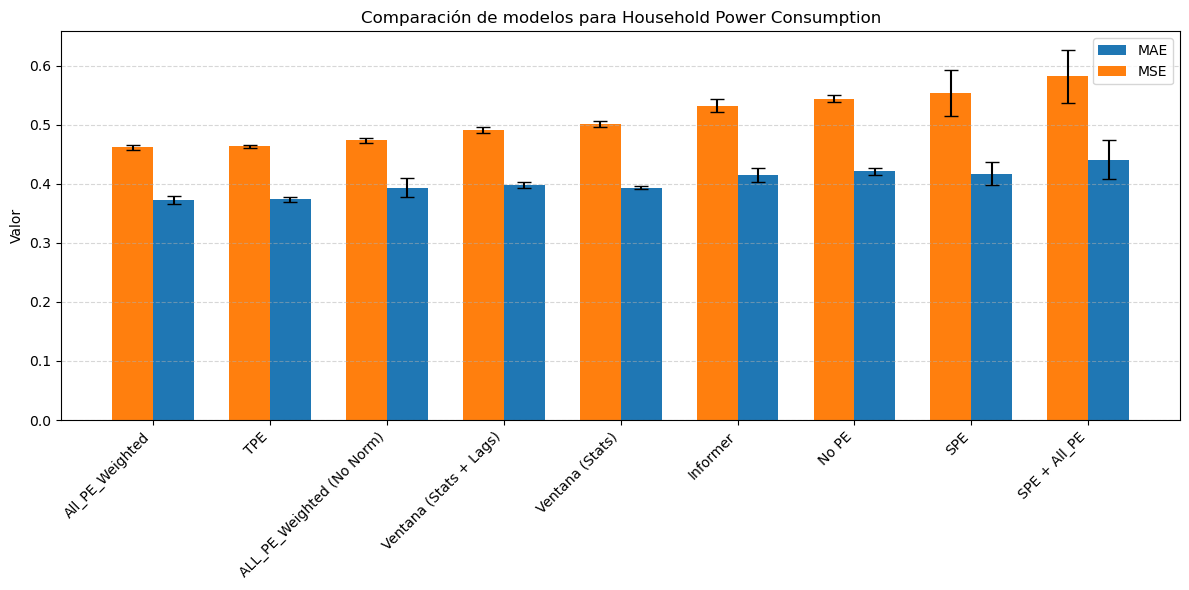

In [93]:
# Mostramos métricas para HPC
plot_metricas_con_error(final_df, titulo="Comparación de modelos para Household Power Consumption")

### Barajando los mejores modelos

Una vez seleccionado el modelo que queremos comprobar, podemos pasar a ejecutar un experimento: comprobar si el positional encoding está realmente ayudando a aportar valor al modelo. Para ello, podemos realizar un pequeño experimento en el cual, mezclar los valores de entrada de referencia para el decoder, y ver si así se obtienen resultados similares a introducirlos originales.

Lo que buscamos es ver si la información añadida por el PE realmente ayuda al modelo a aprender información local, o si por consiguiente, se está desaprovechando cómputo a cambio leves mejoras o incluso empeoramiento.

Al igual que en el apartado anterior, procederemos a la lectura de resultados de 4 modelos:
- Estadísticos + lags original
- Estadísticos + lags desordenado
- Informer original
- Informer desordenado


,Modelo,MAE_Mean,MAPE_Mean,MSE_Mean,MSPE_Mean,RMSE_Mean,TestTime(s)_Mean,TrainTime(s)_Mean,MAE_STD,MAPE_STD,MSE_STD,MSPE_STD,RMSE_STD,TestTime(s)_STD,TrainTime(s)_STD
0,ALL_PE,0.373488,2.251120,0.461892,986.080587,0.679617,350.836037,18652.724426,0.006858,0.091233,0.004841,128.446180,0.003558,5.567514,128.342962
5,TPE,0.374392,2.252478,0.463651,954.171082,0.680918,296.252991,18913.633506,0.004132,0.001750,0.001917,38.396774,0.001408,1.955109,28.792701
2,Informer,0.415272,2.598725,0.532965,1345.903158,0.730005,91.941244,7817.020260,0.012216,0.066858,0.010976,113.730710,0.007540,1.244423,821.270911
4,No PE,0.421343,2.394682,0.544844,1053.862630,0.738126,125.053827,10382.266527,0.005856,0.055825,0.005447,84.204210,0.003690,2.833062,2083.316310
3,Informer (Shuffled),0.419960,2.637963,0.548443,1299.400024,0.740543,85.987744,7523.083485,0.002769,0.082234,0.009148,157.126600,0.006162,0.768127,1508.276486
1,ALL_PE (Shuffled),0.581124,2.427627,0.782092,716.527344,0.884222,330.988508,20842.951120,0.021991,0.106249,0.027368,69.707450,0.015572,6.040981,1877.777867
6,TPE (Shuffled),0.581001,2.740639,0.851115,1022.612895,0.922467,295.005139,20580.513685,0.046717,0.080763,0.024083,95.225204,0.013023,1.204927,2278.562719


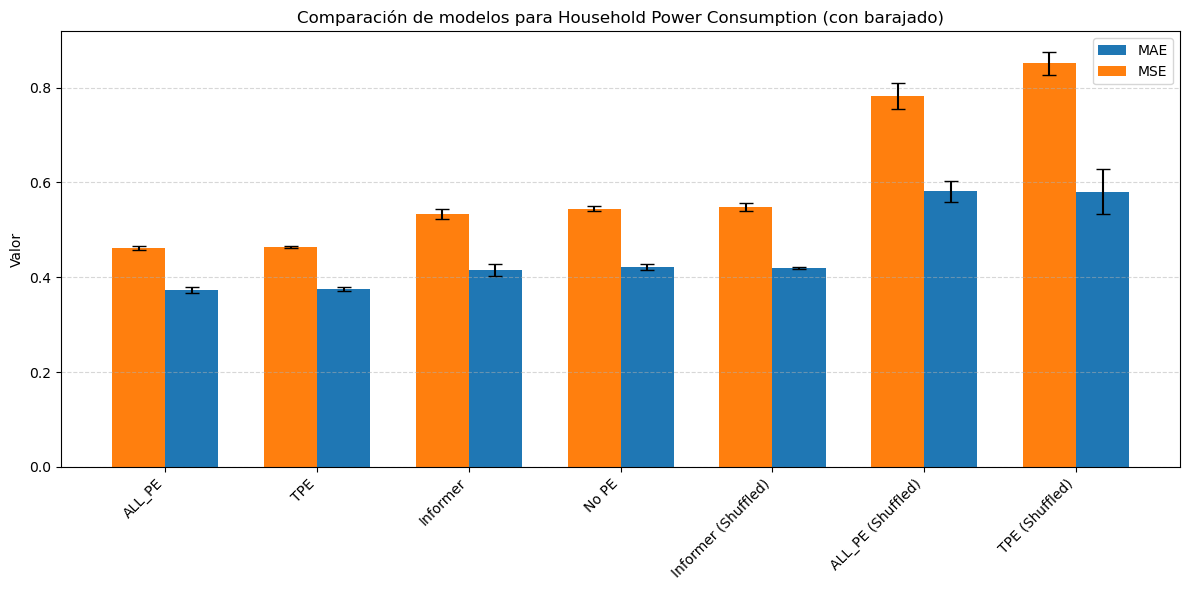

In [94]:
# Ficheros con sus nombres de modelo
model_files = {
    "ALL_PE": "HPC_ALL_PE_v2.csv",
    "ALL_PE (Shuffled)": "HPC_ALL_PE_v2_Shuffled.csv",
    "Informer": "metricas_InformerVanilla_hpc_informer_informer_HPCm_ftM_sl180_ll60_pl60_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_hpc_informer.csv",
    "Informer (Shuffled)": "metricas_InformerVanilla_hpc_informer_shuffled_informer_HPCm_ftM_sl180_ll60_pl60_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_hpc_informer_shuffled.csv",
    "No PE": "HPC_No_PE.csv",
    "TPE": "metricas_InformerVanilla_tpe_weighted_informer_HPCm_ftM_sl180_ll60_pl60_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_tpe_weighted.csv",
    "TPE (Shuffled)": "metricas_InformerVanilla_tpe_weighted_shuffled_informer_HPCm_ftM_sl180_ll60_pl60_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_tpe_weighted_shuffled.csv"
}

dfs = []

for model_name, file_path in model_files.items():
    df = pd.read_csv(file_path)
    #print(file_path)
    df['Modelo'] = model_name  # Añadir columna del modelo

    # Pivotar valores de Mean y STD
    df_mean = df.pivot(index='Modelo', columns='Metric', values='Mean')
    df_std = df.pivot(index='Modelo', columns='Metric', values='STD')

    # Renombrar columnas para distinguir Mean y STD
    df_mean.columns = [f"{col}_Mean" for col in df_mean.columns]
    df_std.columns = [f"{col}_STD" for col in df_std.columns]

    # Combinar ambos
    df_combined = pd.concat([df_mean, df_std], axis=1)

    dfs.append(df_combined)

# Unir todos los modelos
final_df = pd.concat(dfs)

# Resetear índice y ordenar por MSE_Mean
final_df.reset_index(inplace=True)
final_df = final_df.sort_values(by="MSE_Mean")

# Mostramos tabla y gráfico
display(final_df)
plot_metricas_con_error(final_df, titulo="Comparación de modelos para Household Power Consumption (con barajado)")

Podemos apreciar, claramente, que el impacto de mezclar la información de referencia en el encoder afecta de manera considerable a la alternativa que usa ventana de estadísticos, ya que se está rompiendo considerablemente la estructura temporal de los datos. Es un resultado razonable, pues mezclar la información dentro de las ventanas está alterando gravemente la información contenida localmente.

Sin embargo, cuando realizamos el mismo procedimiento con el modelo Informer original, la diferencia es muy poco notable: pasamos apenas de 0.532 de MSE a 0.548. En el caso de las alternativas basadas en estadísticos, se pasa de 0.46 a 0.78, reflejando un empeoramiento significativo en los resultados a diferencia del modelo original.

También se ha evaluado el modelo basado en TPE, debido a su menor varianza y cercanía a los estadísticos. En dicho caso, pasamos de 0.463 a 0.85, siendo aún más notable la diferencia.

Por tanto, podríamos asumir que la información fija aportada por el PE sinusoidal de Informer no está añadiendo suficiente riqueza en datos de larga extensión como este dataset. Si bien, sí que mejora considerablemente el resultado contra un modelo sin ningún tipo de codificación (NoPe En el gráfico), la información añadida es puramente global, y en secuencias de esta longitud, podemos observar cambios de comportamiento a nivel local que pueden ser interesantes de tener en cuenta.

A primera vista, el PE propuesto en ALL_PE_Weighted podría parecer superior, ya que estamos aprovechando dicha información local de utilidad. Sin embargo, tambiém debemos tener en cuenta el encoding basado en TPE, pues ofrece resultados también muy competitivos, y en otros datasets, podría ofrecer un buen resultado, ya que parece ser más estable en sucesivas ejecuciones (menor varianza), y tiene una inferencia más eficiente en tiempo. 

Por lo tanto, será también evaluado con el resto de datasets restantes, debido a que las diferencias en HPC han sido prácticamente marginales.

## Evaluación mediante otros datasets

Una vez definidos los encodings a probar, `TPE` y `All_PE_Weighted`, procederemos a evaluar el rendimiento sobre otros 3 datasets conocidos en el estado del arte:
- **ETTh1**, el dataset de funcionamiento de un sistema eléctrico referenciado en el paper original de Informer, y el cual fue usado para su análisis de rendimiento.
- **Yellow Tripdata**, un conjunto de datos que recopila información acerca de viajes en taxi y su coste asociado. Resulta de interés debido a su posible estacionalidad en horas nocturnas y fines de semana, donde los precios son mayores, e identificar otros patrones (por ejemplo, hora de entrada y salida laboral, etc.). En adelante, para mayor comodidad, lo referenciaremos como `Taxi`.
- **TINA**, cuyo acrónimo proviene de Time-series Industrial Anomaly, donde la gran tarea de interés reside en la detección anomalías y patrones en las mismas.

### ETTh1

Comenzaremos por el dataset de menor tamaño, ETT, el cual es ampliamente utilizado en el estado del arte para la comparativa entre nuevos modelos. Aunque su extensión es bastante reducida, nos permitirá ver el rendimiento del modelo que estamos proponiendo en otro tipo de series, y ver si es lo suficientemente elástico como para adaptarse a diferentes características.

La configuración usada será la misma que en el paper original de Informer para establecer las mismas condiciones. En cuanto a la configuración de la ventana, cuando corresponde, y la longitud de la predicción, se ha establecido:

- Ventana: 24
- Longitud de secuencia: 96
- Longitud de contexto: 48
- Longitud de predicción: 24 (1 día)

A continuación, importaremos los resultados y los graficaremos de la misma forma que el apartado anterior.

,Modelo,MAE_Mean,MAPE_Mean,MSE_Mean,MSPE_Mean,RMSE_Mean,TestTime(s)_Mean,TrainTime(s)_Mean,MAE_STD,MAPE_STD,MSE_STD,MSPE_STD,RMSE_STD,TestTime(s)_STD,TrainTime(s)_STD
0,ALL_PE,0.494661,10.515547,0.465990,40193.949219,0.682334,0.779390,27.822449,0.019507,0.347335,0.027734,2941.5654,0.020266,0.008920,2.565389
5,TPE,0.507179,11.085088,0.489647,45770.907813,0.698881,1.339969,52.732013,0.031240,0.730064,0.048151,7129.3390,0.034805,0.043272,0.954233
2,Informer,0.532375,11.799151,0.545807,48779.951562,0.738659,0.383596,16.819558,0.017099,1.626443,0.020421,13908.2080,0.013775,0.002506,1.748976
1,ALL_PE (Shuffled),0.631257,10.456927,0.689675,36663.685937,0.829999,0.799599,27.664155,0.027637,0.794871,0.046108,6098.2670,0.027873,0.007132,0.196630
6,TPE (Shuffled),0.672846,11.246408,0.803575,42832.119531,0.895662,1.408538,58.641512,0.035790,1.498342,0.066685,12783.6790,0.036937,0.085056,6.365417
3,Informer (Shuffled),0.635849,14.953555,0.875502,77929.382031,0.934864,0.412799,15.953086,0.029589,2.687504,0.072617,27876.7150,0.039130,0.050256,1.473805
4,No PE,0.741918,14.232987,0.923467,76807.512109,0.960007,0.451098,17.335851,0.050922,4.295049,0.084128,46287.2800,0.043059,0.043514,3.149851


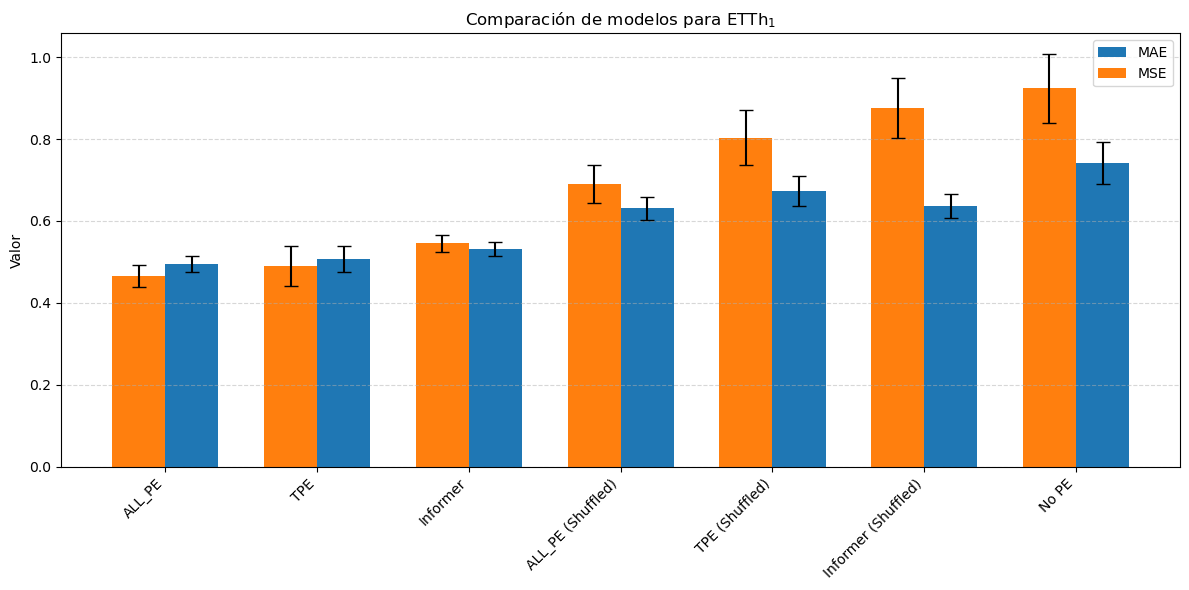

In [95]:
# Ficheros con sus nombres de modelo
model_files = {
    "ALL_PE": "metricas_InformerVanilla_etth1_all_pe_informer_ETTh1_ftM_sl96_ll48_pl24_win24_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_etth1_all_pe.csv",
    "ALL_PE (Shuffled)": "metricas_InformerVanilla_etth1_all_pe_shuffled_informer_ETTh1_ftM_sl96_ll48_pl24_win24_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_etth1_all_pe_shuffled.csv",
    "Informer": "metricas_InformerVanilla_etth1_informer_informer_ETTh1_ftM_sl96_ll48_pl24_win24_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_etth1_informer.csv",
    "Informer (Shuffled)": "metricas_InformerVanilla_etth1_informer_shuffled_informer_ETTh1_ftM_sl96_ll48_pl24_win24_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_etth1_informer_shuffled.csv",
    "No PE": "metricas_InformerVanilla_etth1_nope_informer_ETTh1_ftM_sl96_ll48_pl24_win24_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_etth1_nope.csv",
    "TPE": "metricas_InformerVanilla_etth1_tpe_informer_ETTh1_ftM_sl96_ll48_pl24_win24_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_etth1_tpe.csv",
    "TPE (Shuffled)": "metricas_InformerVanilla_etth1_tpe_shuffled_informer_ETTh1_ftM_sl96_ll48_pl24_win24_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_etth1_tpe_shuffled.csv"
}

dfs = []

for model_name, file_path in model_files.items():
    df = pd.read_csv(file_path)
    #print(file_path)
    df['Modelo'] = model_name  # Añadir columna del modelo

    # Pivotar valores de Mean y STD
    df_mean = df.pivot(index='Modelo', columns='Metric', values='Mean')
    df_std = df.pivot(index='Modelo', columns='Metric', values='STD')

    # Renombrar columnas para distinguir Mean y STD
    df_mean.columns = [f"{col}_Mean" for col in df_mean.columns]
    df_std.columns = [f"{col}_STD" for col in df_std.columns]

    # Combinar ambos
    df_combined = pd.concat([df_mean, df_std], axis=1)

    dfs.append(df_combined)

# Unir todos los modelos
final_df = pd.concat(dfs)

# Resetear índice y ordenar por MSE_Mean
final_df.reset_index(inplace=True)
final_df = final_df.sort_values(by="MSE_Mean")

# Mostramos tabla y gráfico
display(final_df)
plot_metricas_con_error(final_df, titulo=f"Comparación de modelos para ETTh$_1$")

Podemos apreciar resultados muy diferentes a los vistos para una secuencia más larga:

- El rendimiento de All_PE siguen siendo el ganador, pero esta vez, con mayor diferencia, siendo esta vez de 0.04, que es 40 veces mayor a la diferencia existente en HPC. Además, la varianza de TPE es ahora mayor a la de ALL_PE, tal y como se puede verificar tanto numéricamente como en la barra de error.
- El rendimiento de Informer, curiosamente, parece ser más cercano en este conjunto. Podemos ver que, además, cuando realizamos el mezclado, ahora es el modelo de Informer el que más impacto aprecia en sus resultados. De alguna manera, para secuencias más cortas, una simple codificación sinusoidal parece codificar adecuadamente la información.
- En el caso de los dos modelos propuestos, pero mezclados, el empeoramiento sigue siendo notable como hasta ahora.

Por tanto, este apartado nos arroja un resultado bastante interesante, y es que todo apunta que, a secuencias más largas, y de mayor complejidad, el PE tradicional basado en senos y cosenos tiene grandes carencias, potencialmente por la falta de aprovechamiento de la localidad, ya que series de gran tamaño podemos encontrar diferentes subsecuencias a las que debemos adaptarnos. Pero, cuando la serie es más corta, como esta, dicha información podría no ser tan variable, y de ahí que un enfoque global como Informer puedea seguir manteniendose cercano a los mecanismos locales.

También podríamos sumar el impacto de la profundidad de las arquitecturas y estructuras de datos: a mayor tamaño de entrada, mayor número de parámetros, y por ende, más dificultad de propagación del aprendizaje del encoding a través de la arqutectura. Sin embargo, para verificarlo, debemos seguir evaluando más datasets.

### Yellow Trip Data (Taxi)

A continuación, es el turno de un dataset de extensión similar a HPC, por lo que se usarán los mismos parámetros que en este para la evaluación del rendimiento. De la misma forma, se han recopilado resultados para All_PE, TPE e Informer.

- Ventana: 60
- Longitud de secuencia: 180
- Longitud de contexto: 60
- Longitud de predicción: 60 

,Modelo,MAE_Mean,MAPE_Mean,MSE_Mean,MSPE_Mean,RMSE_Mean,TestTime(s)_Mean,TrainTime(s)_Mean,MAE_STD,MAPE_STD,MSE_STD,MSPE_STD,RMSE_STD,TestTime(s)_STD,TrainTime(s)_STD
2,Informer,0.003987,0.039024,0.000019,0.001833,0.004259,82.538561,13989.064623,0.000795,0.009835,0.000007,0.001036,0.000818,5.488924,5934.676716
3,Informer (Shuffled),0.005038,0.097463,0.000036,0.051139,0.005758,78.813051,11306.873362,0.001554,0.056254,0.000018,0.061900,0.001733,0.599747,6847.438450
0,ALL_PE,0.004886,0.070728,0.000043,0.013416,0.005405,461.615646,45449.602914,0.003473,0.012457,0.000049,0.004287,0.003662,18.928417,17286.956258
1,ALL_PE (Shuffled),0.072033,0.606673,0.130236,7.490809,0.216902,417.420240,38286.778342,0.095835,0.762853,0.183817,10.549806,0.288427,37.031800,13163.875079


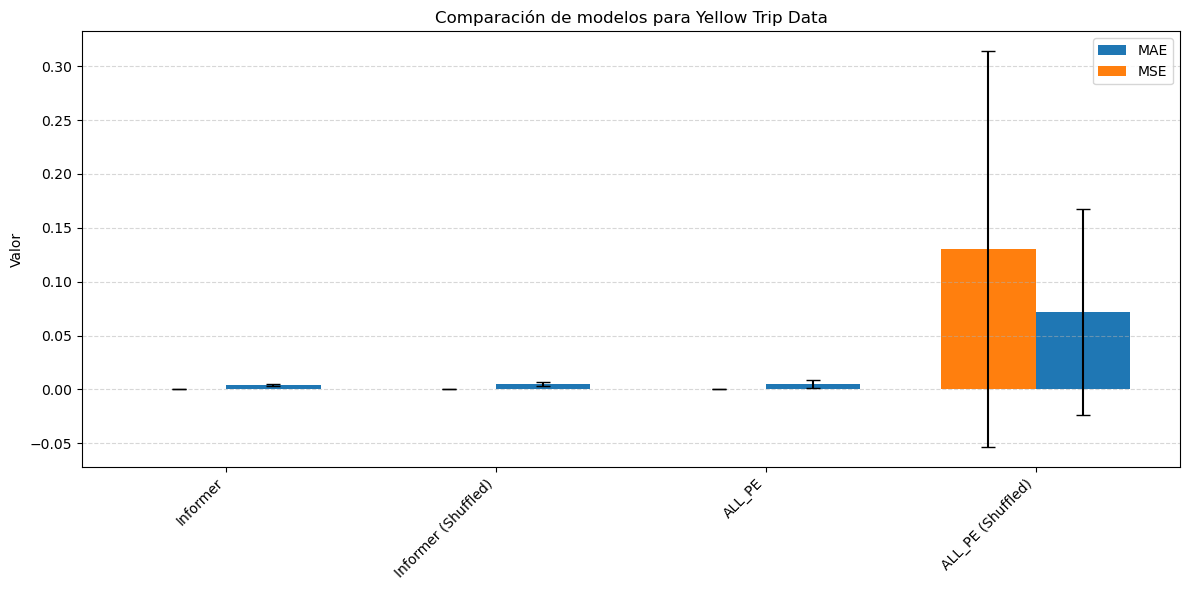

In [96]:
# Ficheros con sus nombres de modelo
model_files = {
    "ALL_PE": "metricas_InformerVanilla_taxi_all_pe_weighted_informer_Taxi_ftM_sl180_ll60_pl60_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_taxi_all_pe_weighted.csv",
    "ALL_PE (Shuffled)": "metricas_InformerVanilla_taxi_all_pe_shuffled_informer_Taxi_ftM_sl180_ll60_pl60_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_taxi_all_pe_shuffled.csv",
    "Informer": "metricas_InformerVanilla_taxi_informer_informer_Taxi_ftM_sl180_ll60_pl60_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_taxi_informer.csv",
    "Informer (Shuffled)": "metricas_InformerVanilla_taxi_informer_shuffled_informer_Taxi_ftM_sl180_ll60_pl60_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_taxi_informer_shuffled.csv",
    #"No PE": "metricas_InformerVanilla_etth1_nope_informer_ETTh1_ftM_sl96_ll48_pl24_win24_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_etth1_nope.csv",
    #"TPE": "metricas_InformerVanilla_etth1_tpe_informer_ETTh1_ftM_sl96_ll48_pl24_win24_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_etth1_tpe.csv",
    #"TPE (Shuffled)": "metricas_InformerVanilla_etth1_tpe_shuffled_informer_ETTh1_ftM_sl96_ll48_pl24_win24_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_etth1_tpe_shuffled.csv"
}

dfs = []

for model_name, file_path in model_files.items():
    df = pd.read_csv(file_path)
    #print(file_path)
    df['Modelo'] = model_name  # Añadir columna del modelo

    # Pivotar valores de Mean y STD
    df_mean = df.pivot(index='Modelo', columns='Metric', values='Mean')
    df_std = df.pivot(index='Modelo', columns='Metric', values='STD')

    # Renombrar columnas para distinguir Mean y STD
    df_mean.columns = [f"{col}_Mean" for col in df_mean.columns]
    df_std.columns = [f"{col}_STD" for col in df_std.columns]

    # Combinar ambos
    df_combined = pd.concat([df_mean, df_std], axis=1)

    dfs.append(df_combined)

# Unir todos los modelos
final_df = pd.concat(dfs)

# Resetear índice y ordenar por MSE_Mean
final_df.reset_index(inplace=True)
final_df = final_df.sort_values(by="MSE_Mean")

# Mostramos tabla y gráfico
display(final_df)
plot_metricas_con_error(final_df, titulo=f"Comparación de modelos para Yellow Trip Data")